<a href="https://colab.research.google.com/github/SravaniKarri137/Stroke-Identification-A-Machine-Learning-Based-Diagnostic-Model-Using-Neuroimages/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training SVM...
Accuracy for SVM: 0.96
Classification Report for SVM:
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       305
      stroke       0.98      0.92      0.95       196

    accuracy                           0.96       501
   macro avg       0.97      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



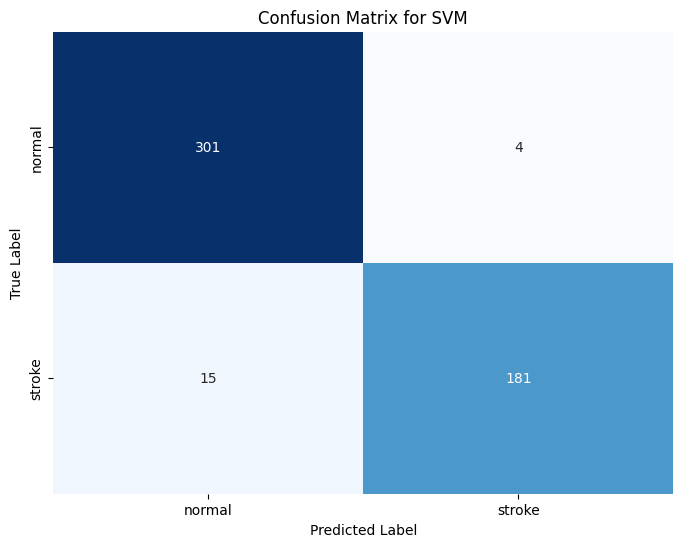

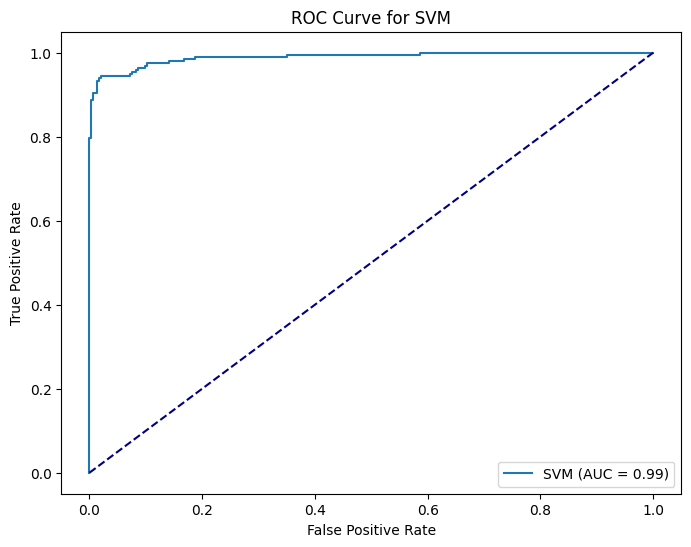

Training Decision Tree...
Accuracy for Decision Tree: 0.92
Classification Report for Decision Tree:
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93       305
      stroke       0.91      0.89      0.90       196

    accuracy                           0.92       501
   macro avg       0.92      0.91      0.92       501
weighted avg       0.92      0.92      0.92       501



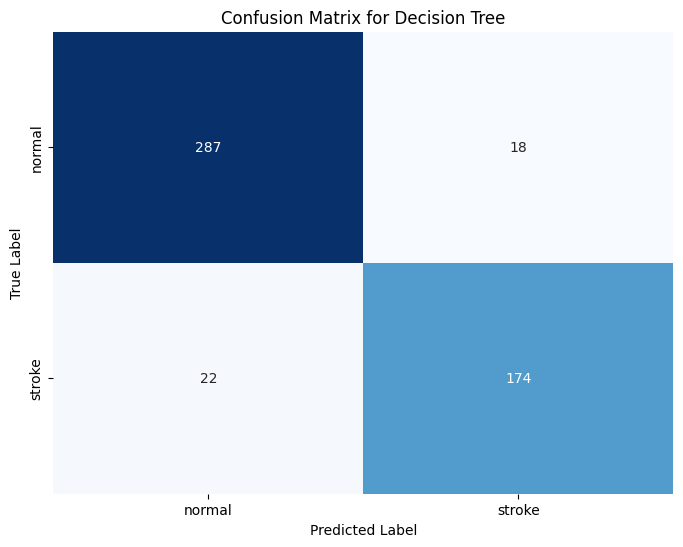

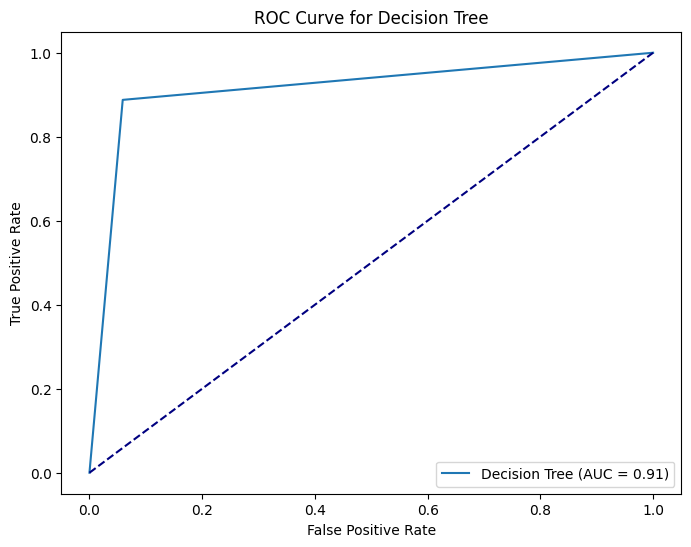

Training Random Forest...
Accuracy for Random Forest: 0.96
Classification Report for Random Forest:
              precision    recall  f1-score   support

      normal       0.94      1.00      0.97       305
      stroke       1.00      0.91      0.95       196

    accuracy                           0.96       501
   macro avg       0.97      0.95      0.96       501
weighted avg       0.97      0.96      0.96       501



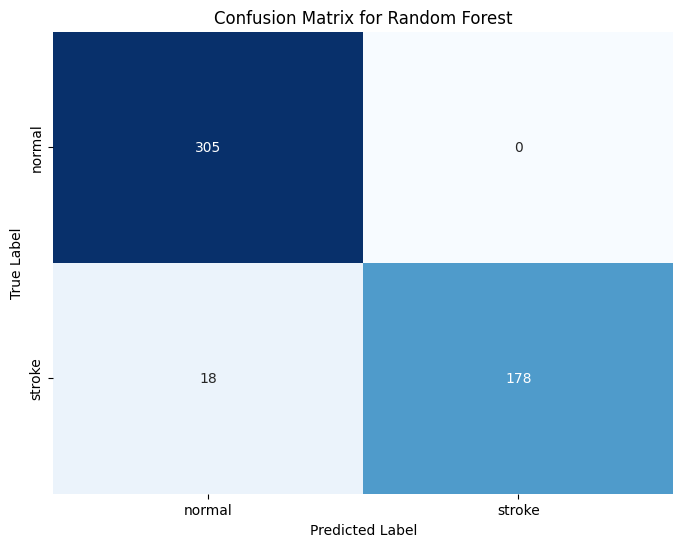

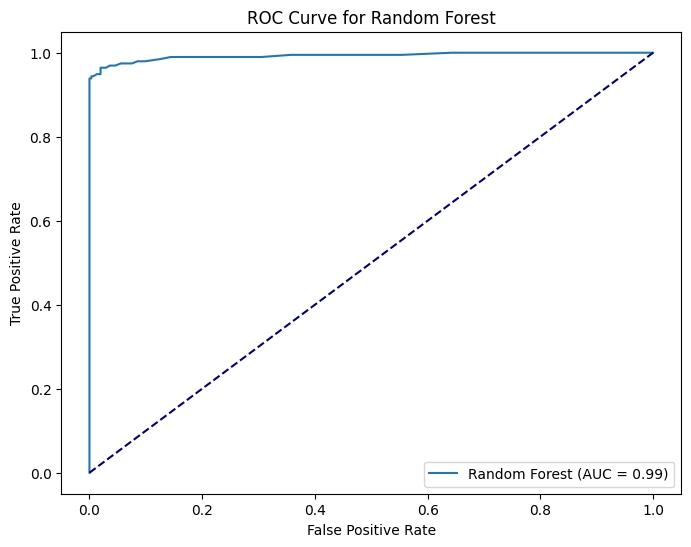

Training K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.94
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

      normal       0.95      0.94      0.95       305
      stroke       0.91      0.92      0.92       196

    accuracy                           0.94       501
   macro avg       0.93      0.93      0.93       501
weighted avg       0.94      0.94      0.94       501



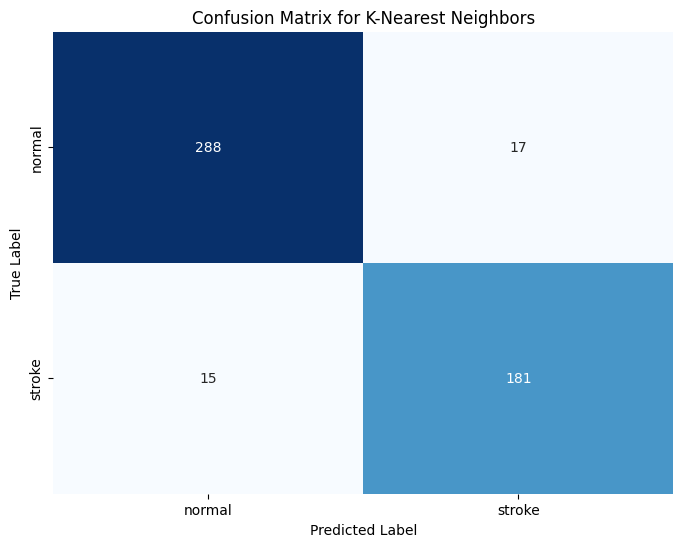

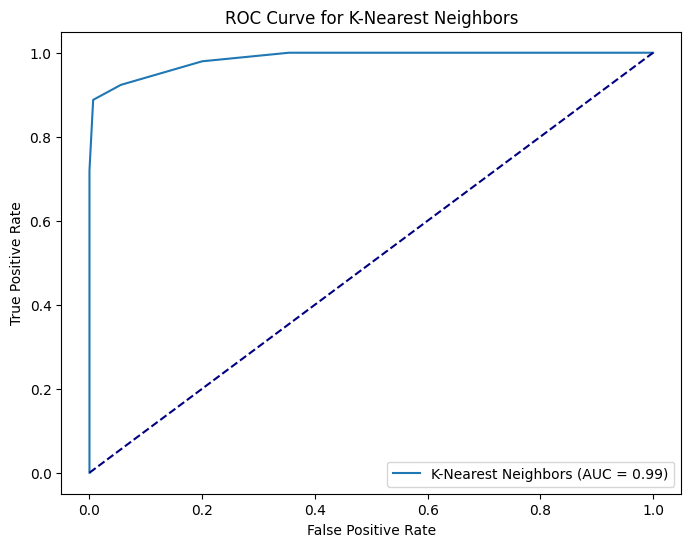


Summary of results:

SVM Results:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       305
      stroke       0.98      0.92      0.95       196

    accuracy                           0.96       501
   macro avg       0.97      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501

Confusion Matrix:
[[301   4]
 [ 15 181]]
AUC: 0.99

Decision Tree Results:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93       305
      stroke       0.91      0.89      0.90       196

    accuracy                           0.92       501
   macro avg       0.92      0.91      0.92       501
weighted avg       0.92      0.92      0.92       501

Confusion Matrix:
[[287  18]
 [ 22 174]]
AUC: 0.91

Random Forest Results:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   s

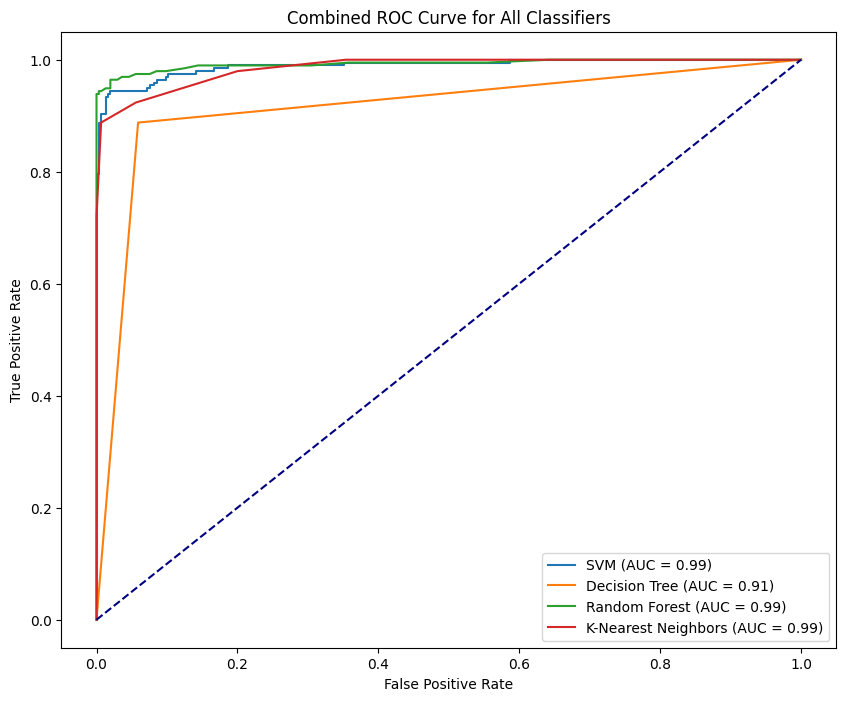

In [1]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import numpy as np
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)  # Keep images as PIL Image objects
    return images

def preprocess_image(img, target_size=(100, 100)):
    img = img.convert('L')  # Convert to grayscale
    img = img.resize(target_size)  # Resize image
    return np.array(img)

def extract_features_parallel(images):
    num_processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=num_processes) as pool:
        features = pool.map(extract_features_single, images)
    return features

def extract_features_single(img):
    # HOG features
    hog_feat = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    # LBP features
    lbp_feat = local_binary_pattern(img, 8, 1, method='uniform').ravel()
    # Gabor filter features
    gabor_feat = np.array([np.mean(gabor(img, frequency=freq)[0]) for freq in [0.1, 0.5, 1.0]])

    # Concatenate features
    combined_feat = np.concatenate((hog_feat, lbp_feat, gabor_feat))
    return combined_feat

# Load images
normal_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Normal')
stroke_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Stroke')

# Preprocess images
normal_images_processed = [preprocess_image(img) for img in normal_images]
stroke_images_processed = [preprocess_image(img) for img in stroke_images]

# Extract features
normal_features = extract_features_parallel(normal_images_processed)
stroke_features = extract_features_parallel(stroke_images_processed)

# Combine features and labels
X = normal_features + stroke_features
y = ['normal'] * len(normal_features) + ['stroke'] * len(stroke_features)

# Encode labels to binary format
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='linear', probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.2f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # ROC curve
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:  # for SVM without probability=True
        y_prob = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True),
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc
    }

# Summary of results
print("\nSummary of results:")
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, classifiers[name].predict(X_test), target_names=label_encoder.classes_))
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"AUC: {metrics['auc']:.2f}")

# Plot combined ROC curves for all classifiers
plt.figure(figsize=(10, 8))
for name, metrics in results.items():
     plt.plot(metrics['fpr'], metrics['tpr'], label=f'{name} (AUC = {metrics["auc"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for All Classifiers')
plt.legend(loc='lower right')
plt.show()


